# Étude de la Consommation Énergétique des Bâtiments de Seattle

**Problématique** : Prédire la consommation totale d'énergie (`SiteEnergyUse(kBtu)`) et évaluer la pertinence de l' `ENERGYSTARScore` dans la modélisation pour les bâtiments non-résidentiels.

---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import skew, kurtosis

warnings.filterwarnings('ignore')

# Configuration esthétique premium
sns.set_theme(style="whitegrid", palette="viridis", context="talk")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['font.family'] = 'sans-serif'

DATA_URL = "https://raw.githubusercontent.com/MouslyDiaw/handson-machine-learning/refs/heads/master/data/2016_Building_Energy_Benchmarking.csv"

print(" Environnement configuré et prêt pour l'analyse.")

 Environnement configuré et prêt pour l'analyse.


## 1. Chargement et Nettoyage des Données

Nous filtrons les données pour nous concentrer sur les bâtiments **non-résidentiels** et nous supprimons les variables non pertinentes pour notre problématique de prédiction.
Comme il s'agit de predire la consommation totale d'énergie et les émissions de CO2 des bâtiments non résidentiels, nous supprimons allons filtrer la variable TypeBuilding pour conserver que les bâtiments non résidentiels.

Pour le choix des variables, nous avons juger pertinente que de garder des variables qui apportent des informations pertinentes pour prédire la consommation d'énergie et les émissions de CO2 des bâtiments non résidentiels.
Enfin, pour eviter le data leakage, nous avons supprimé toutes les variables donnant des informations sur relatives à la consommation d'energie

In [ ]:
df_raw = pd.read_csv(DATA_URL)
print(f"Taille initiale : {df_raw.shape}")

# Filtrage Non-Résidentiel
residential_types = ['Multifamily LR (1-4)', 'Multifamily MR (5-9)', 'Multifamily HR (10+)']
df = df_raw[~df_raw['BuildingType'].isin(residential_types)].copy()

# Suppression des colonnes spécifiées
cols_to_drop = [
    'OSEBuildingID', 'DataYear', 'PropertyName', 'City', 'State',
    'TaxParcelIdentificationNumber', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)',
    'DefaultData', 'Comments', "NaturalGas(kBtu)", 'ComplianceStatus', 'Outlier',
    'TotalGHGEmissions', 'GHGEmissionsIntensity',"Address",'SteamUse(kBtu)', 'Electricity(kBtu)','Electricity(kWh)', 'NaturalGas(therms)',
]

df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)

# Nettoyage cible
df = df[df['SiteEnergyUse(kBtu)'] > 0].dropna(subset=['SiteEnergyUse(kBtu)'])

print(f"Taille finale après nettoyage : {df.shape}")

Taille initiale : (3376, 46)
Taille finale après nettoyage : (1650, 23)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1650 entries, 0 to 3375
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     1650 non-null   object 
 1   PrimaryPropertyType              1650 non-null   object 
 2   ZipCode                          1634 non-null   float64
 3   CouncilDistrictCode              1650 non-null   int64  
 4   Neighborhood                     1650 non-null   object 
 5   Latitude                         1650 non-null   float64
 6   Longitude                        1650 non-null   float64
 7   YearBuilt                        1650 non-null   int64  
 8   NumberofBuildings                1650 non-null   float64
 9   NumberofFloors                   1650 non-null   int64  
 10  PropertyGFATotal                 1650 non-null   int64  
 11  PropertyGFAParking               1650 non-null   int64  
 12  PropertyGFABuilding(s)   

### 1.1 Aperçu des Données

In [ ]:
# Affichage des premières lignes
print(" Aperçu des premières lignes du dataset:")
display(df.head())

print(f" État actuel de la base :")
print(f"- Nombre d'observations (lignes) : {df.shape[0]}")
print(f"- Nombre de variables (colonnes)  : {df.shape[1]}")

 Aperçu des premières lignes du dataset:


,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEnergyUse(kBtu)
0,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,7226362.5
1,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,8387933.0
2,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,72587024.0
3,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,6794584.0
4,NonResidential,Hotel,98121.0,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,14172606.0


 État actuel de la base :
- Nombre d'observations (lignes) : 1650
- Nombre de variables (colonnes)  : 23


### 1.2 Types de Variables

In [ ]:
# Affichage des types de variables
print("Types de variables:\n")
print(df.dtypes)

print("\n" + "="*80)
print(" Résumé des informations:")
print("="*80)
df.info()

Types de variables:

BuildingType                        object
PrimaryPropertyType                 object
ZipCode                            float64
CouncilDistrictCode                  int64
Neighborhood                        object
Latitude                           float64
Longitude                          float64
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLargestPropertyUseType        object
SecondLargestPropertyUseTypeGFA    float64
ThirdLargestPropertyUseType         object
ThirdLargestPropertyUseTypeGFA     float64
YearsENERGYSTARCertified            object
ENERGYSTARScore                    float64
SiteEnergyUse(kBtu)              

## 2. Analyse Statistique Descriptive

Nous presentons quelques statistiques descriptives pour comprendre la distribution de nos variables clés.

In [ ]:
stats_desc = df.describe().T
stats_desc['skewness'] = df.apply(lambda x: skew(x.dropna()) if x.dtype != 'object' else np.nan)
stats_desc['kurtosis'] = df.apply(lambda x: kurtosis(x.dropna()) if x.dtype != 'object' else np.nan)

display(stats_desc.style.background_gradient(cmap='YlGnBu'))

print(f"\nSkewness de la cible (SiteEnergyUse) : {df['SiteEnergyUse(kBtu)'].skew():.2f}")

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
ZipCode,1634.000000,98116.745410,18.358612,98006.000000,98105.000000,98109.000000,98124.000000,98199.000000,1.291509,8.906639
CouncilDistrictCode,1650.000000,4.355152,2.192921,1.000000,2.000000,4.000000,7.000000,7.000000,0.008695,-1.577423
Latitude,1650.000000,47.615853,0.048021,47.499170,47.585315,47.612335,47.649400,47.733870,0.226694,-0.223643
Longitude,1650.000000,-122.332867,0.024475,-122.411820,-122.343093,-122.332955,-122.321770,-122.258640,-0.064220,0.756893
YearBuilt,1650.000000,1961.820606,32.815534,1900.000000,1930.000000,1965.000000,1989.000000,2015.000000,-0.287290,-1.052136
NumberofBuildings,1650.000000,1.170303,2.945548,0.000000,1.000000,1.000000,1.000000,111.000000,32.296075,1175.979265
NumberofFloors,1650.000000,4.142424,6.594535,0.000000,1.000000,2.000000,4.000000,99.000000,6.009440,52.062690
PropertyGFATotal,1650.000000,118562.827273,297245.449259,11285.000000,29392.500000,49059.000000,105090.250000,9320156.000000,19.324374,560.440298
PropertyGFAParking,1650.000000,13038.684242,42483.013144,0.000000,0.000000,0.000000,0.000000,512608.000000,5.188630,34.984666
PropertyGFABuilding(s),1650.000000,105524.143030,283926.341675,3636.000000,28332.000000,47037.500000,94659.750000,9320156.000000,21.882573,675.604529



Skewness de la cible (SiteEnergyUse) : 17.97


**Interprétation** :
- La **skewness (Asymétrie)** élevée de `SiteEnergyUse(kBtu)` indique une distribution fortement étalée vers la droite (présence de très gros consommateurs).
- Le **kurtosis(Aplatissement)** suggère des queues de distribution épaisses, confirmant la présence d'outliers significatifs.

### 2.1 Interprétation Automatique des Distributions

Analysons les variables qui nécessitent une attention particulière selon les seuils standards :
- **Skewness** : [-0.5, +0.5] = symétrique  | [0.5, 1] = modéré  | >1 = fort
- **Kurtosis** : [-2, +2] = normal  | [2, 4] = modéré  | >4 = extrême

In [ ]:
# Fonction d'interprétation automatique
def interpret_distribution(col_name, skew_val, kurt_val):
    # Interprétation Skewness
    if abs(skew_val) <= 0.5:
        skew_msg = f" {col_name}: Distribution quasi-symétrique (skewness={skew_val:.2f})"
    elif 0.5 < abs(skew_val) <= 1:
        skew_msg = f" {col_name}: Asymétrie modérée (skewness={skew_val:.2f})"
    else:
        skew_msg = f" {col_name}: Asymétrie FORTE (skewness={skew_val:.2f}) → Transformation recommandée"

    # Interprétation Kurtosis
    if abs(kurt_val) <= 2:
        kurt_msg = f"    Kurtosis normal (kurtosis={kurt_val:.2f})"
    elif 2 < abs(kurt_val) <= 4:
        kurt_msg = f"    Queues modérément épaisses (kurtosis={kurt_val:.2f})"
    else:
        kurt_msg = f"    Queues TRÈS épaisses (kurtosis={kurt_val:.2f}) → Outliers significatifs"

    return skew_msg, kurt_msg

# Analyse des variables clés
print("DIAGNOSTIC AUTOMATIQUE DES DISTRIBUTIONS")
print("="*40)

key_vars = ['SiteEnergyUse(kBtu)', 'PropertyGFATotal', 'ENERGYSTARScore', 'YearBuilt']

for var in key_vars:
    if var in df.columns:
        skew_val = df[var].skew()
        kurt_val = df[var].kurtosis()

        skew_msg, kurt_msg = interpret_distribution(var, skew_val, kurt_val)
        print(f"\n{skew_msg}")
        print(kurt_msg)

print("RECOMMANDATIONS POUR LA MODÉLISATION")
print("="*37)
# Recommandations automatiques
if df['SiteEnergyUse(kBtu)'].skew() > 1:
    print(" Appliquer une transformation logarithmique à SiteEnergyUse(kBtu)")

if df['SiteEnergyUse(kBtu)'].kurtosis() > 4:
    print(" Examiner et potentiellement traiter les outliers de SiteEnergyUse(kBtu)")

if 'PropertyGFATotal' in df.columns and df['PropertyGFATotal'].skew() > 1:
    print(" Considérer une transformation log pour PropertyGFATotal")

print("\n")

DIAGNOSTIC AUTOMATIQUE DES DISTRIBUTIONS

 SiteEnergyUse(kBtu): Asymétrie FORTE (skewness=17.97) → Transformation recommandée
    Queues TRÈS épaisses (kurtosis=441.31) → Outliers significatifs

 PropertyGFATotal: Asymétrie FORTE (skewness=19.34) → Transformation recommandée
    Queues TRÈS épaisses (kurtosis=562.15) → Outliers significatifs

 ENERGYSTARScore: Asymétrie modérée (skewness=-0.77)
    Kurtosis normal (kurtosis=-0.51)

 YearBuilt: Distribution quasi-symétrique (skewness=-0.29)
    Kurtosis normal (kurtosis=-1.05)
RECOMMANDATIONS POUR LA MODÉLISATION
 Appliquer une transformation logarithmique à SiteEnergyUse(kBtu)
 Examiner et potentiellement traiter les outliers de SiteEnergyUse(kBtu)
 Considérer une transformation log pour PropertyGFATotal




## 3. Analyse des Valeurs Manquantes

Nous analysons les valeurs manquantes, afin de déterminer la stratégie à adopter pour évaluer la fiabilité de l'`ENERGYSTARScore`.

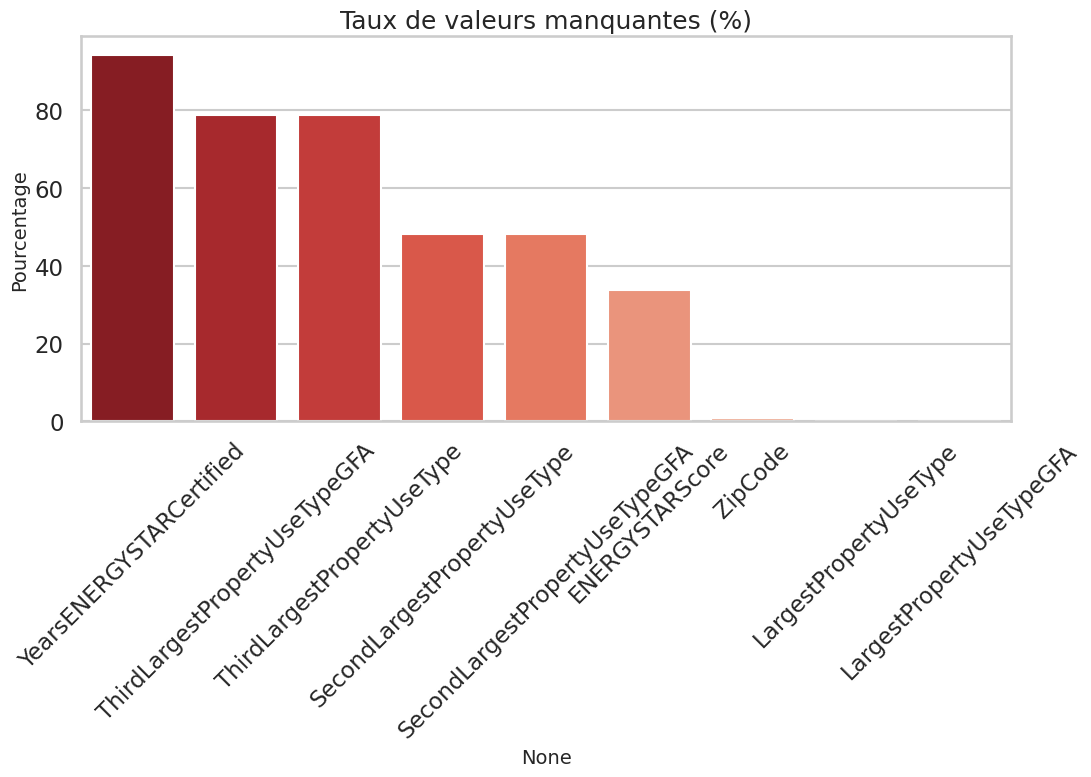

Taux de remplissage de l'ENERGYSTARScore : 66.24%


In [ ]:
plt.figure(figsize=(12, 5))
missing_data = df.isnull().mean() * 100
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

if not missing_data.empty:
    sns.barplot(x=missing_data.index, y=missing_data.values, palette='Reds_r')
    plt.xticks(rotation=45)
    plt.title("Taux de valeurs manquantes (%)")
    plt.ylabel("Pourcentage")
    plt.show()
else:
    print("Aucune valeur manquante détectée dans les colonnes restantes.")

print(f"Taux de remplissage de l'ENERGYSTARScore : {100 - (df['ENERGYSTARScore'].isnull().mean()*100):.2f}%")

**Observation** : On constate que la variable `ENERGYSTARScore` présente un taux de valeurs manquantes assez important. Nous pouvons essayer de voir si ce manque est corrélé au type de bâtiment.

## 4. Analyse de l'ENERGYSTARScore

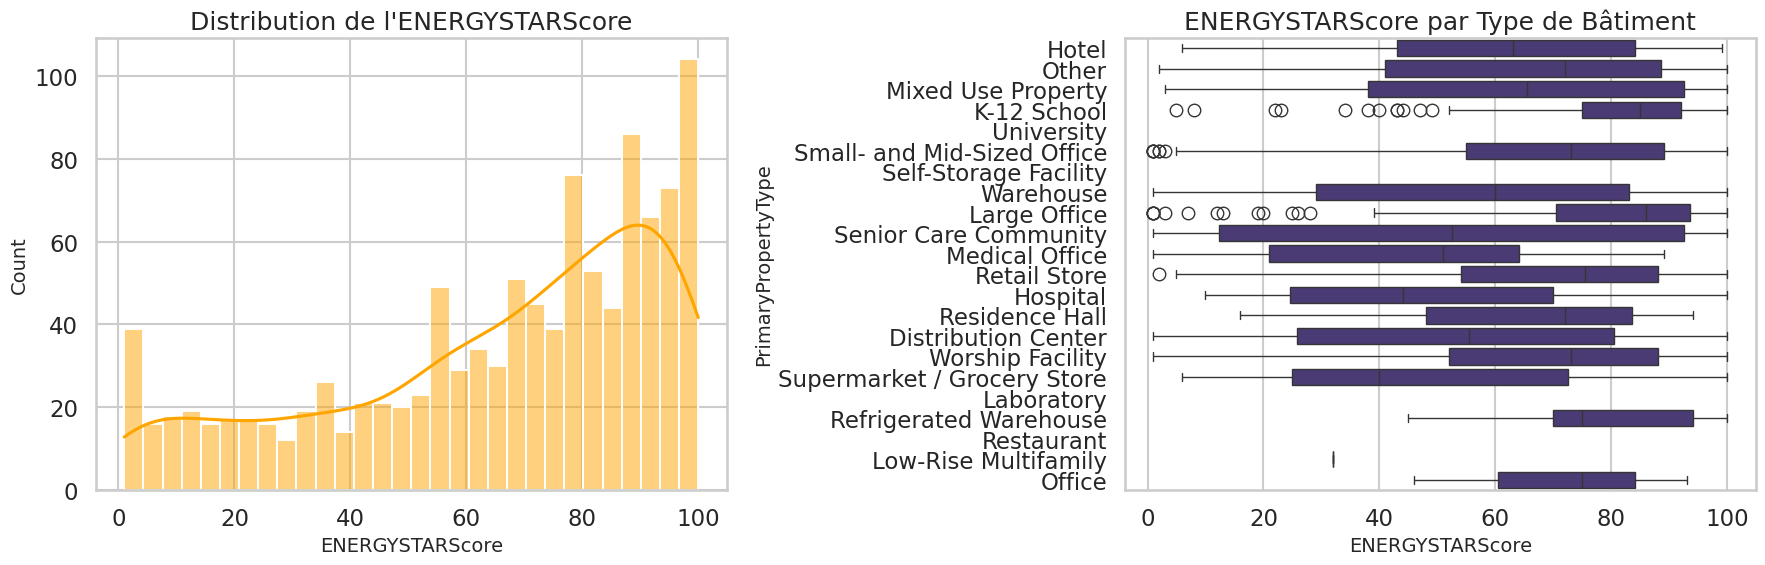

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(df['ENERGYSTARScore'].dropna(), bins=30, kde=True, ax=ax1, color='orange')
ax1.set_title("Distribution de l'ENERGYSTARScore")

sns.boxplot(data=df, x='ENERGYSTARScore', y='PrimaryPropertyType', ax=ax2)
ax2.set_title("ENERGYSTARScore par Type de Bâtiment")

plt.tight_layout()
plt.show()

**Interprétation** :
- Nous voyons que le score est distribué de manière assez biforme avec des pics vers les scores élevés (bâtiments efficaces) et très bas.
- Certains types de bâtiments semblent avoir des scores systématiquement plus bas ou plus de variabilité.

## 5. Analyse de la Variable Cible & Transformation

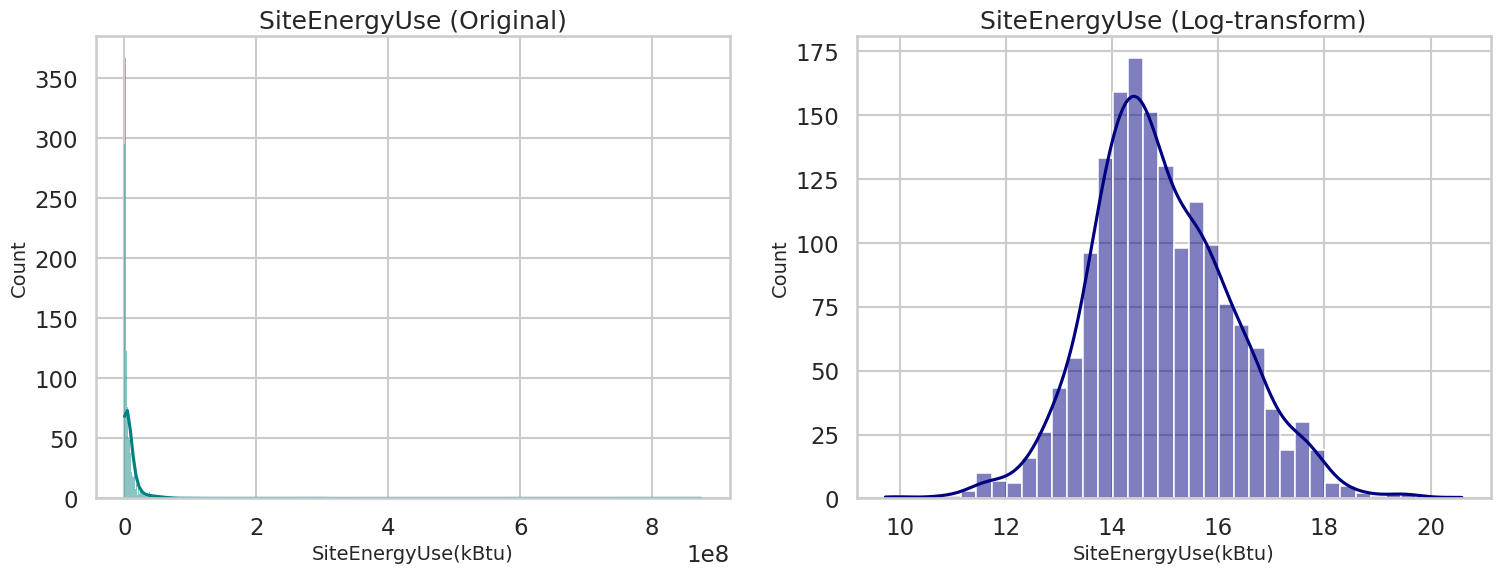

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(df['SiteEnergyUse(kBtu)'], kde=True, ax=ax[0], color='teal')
ax[0].set_title("SiteEnergyUse (Original)")

sns.histplot(np.log(df['SiteEnergyUse(kBtu)']), kde=True, ax=ax[1], color='navy')
ax[1].set_title("SiteEnergyUse (Log-transform)")
plt.show()

**Note** : La transformation logarithmique rend la distribution beaucoup plus proche d'une distribution normale (gaussienne).

## 6. Analyse de l'Impact : Ancienneté et Surface

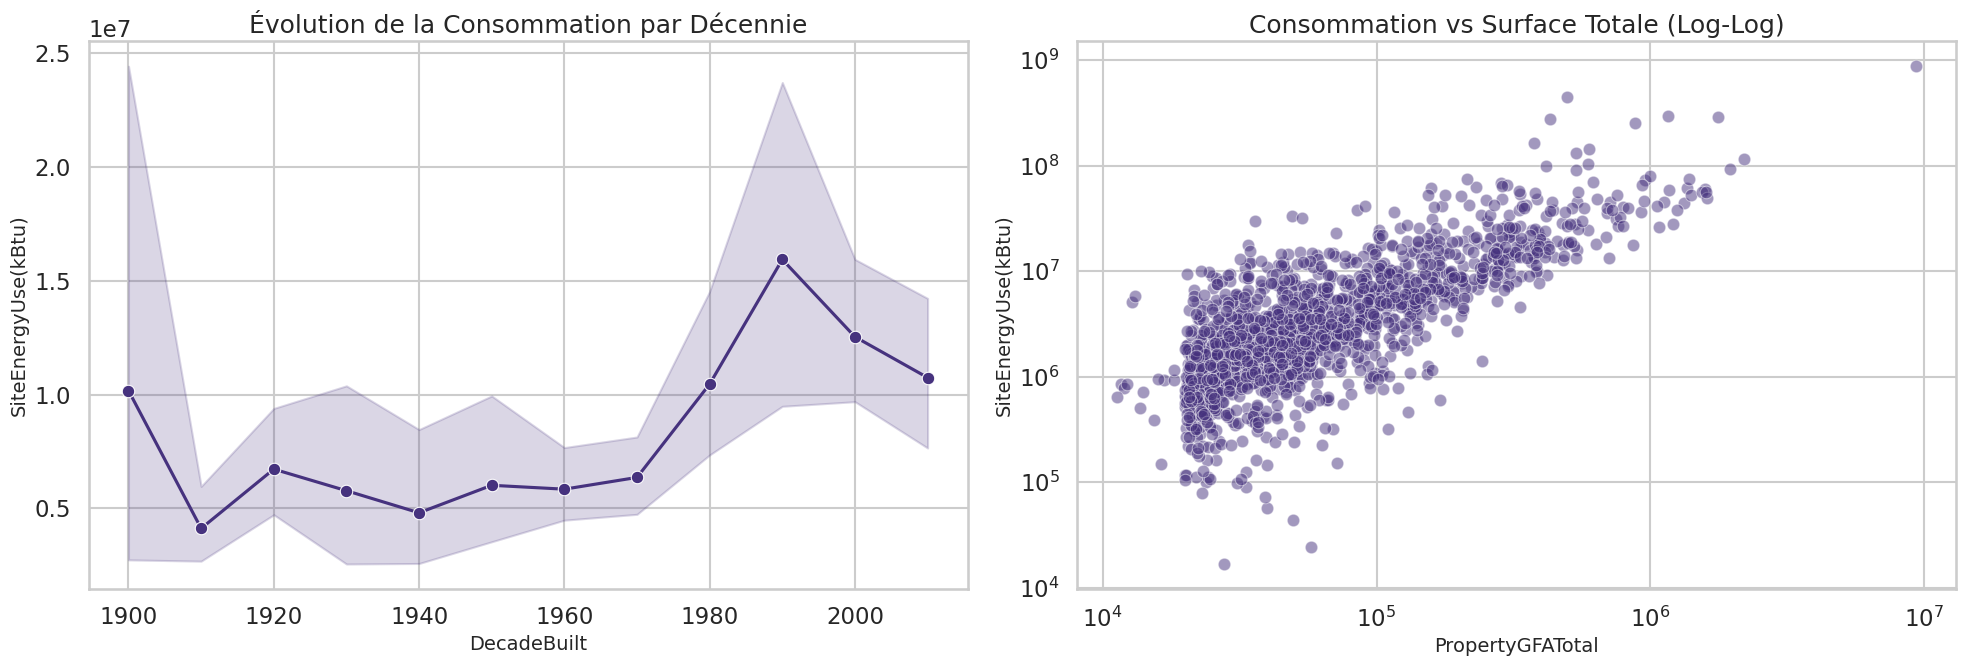

In [ ]:
# Création de décennies pour YearBuilt
df['DecadeBuilt'] = (df['YearBuilt'] // 10) * 10

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

sns.lineplot(data=df, x='DecadeBuilt', y='SiteEnergyUse(kBtu)', ax=ax1, marker='o')
ax1.set_title("Évolution de la Consommation par Décennie")

sns.scatterplot(data=df, x='PropertyGFATotal', y='SiteEnergyUse(kBtu)', alpha=0.5, ax=ax2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("Consommation vs Surface Totale (Log-Log)")

plt.tight_layout()
plt.show()

**Observations** :
- La relation entre `PropertyGFATotal` et la consommation est extrêmement forte et linéaire en échelle log-log.
- L'ancienneté montre des tendances intéressantes, avec parfois des bâtiments anciens mieux isolés ou rénovés par rapport à certaines périodes intermédiaires.

## 7. Matrice de Corrélation

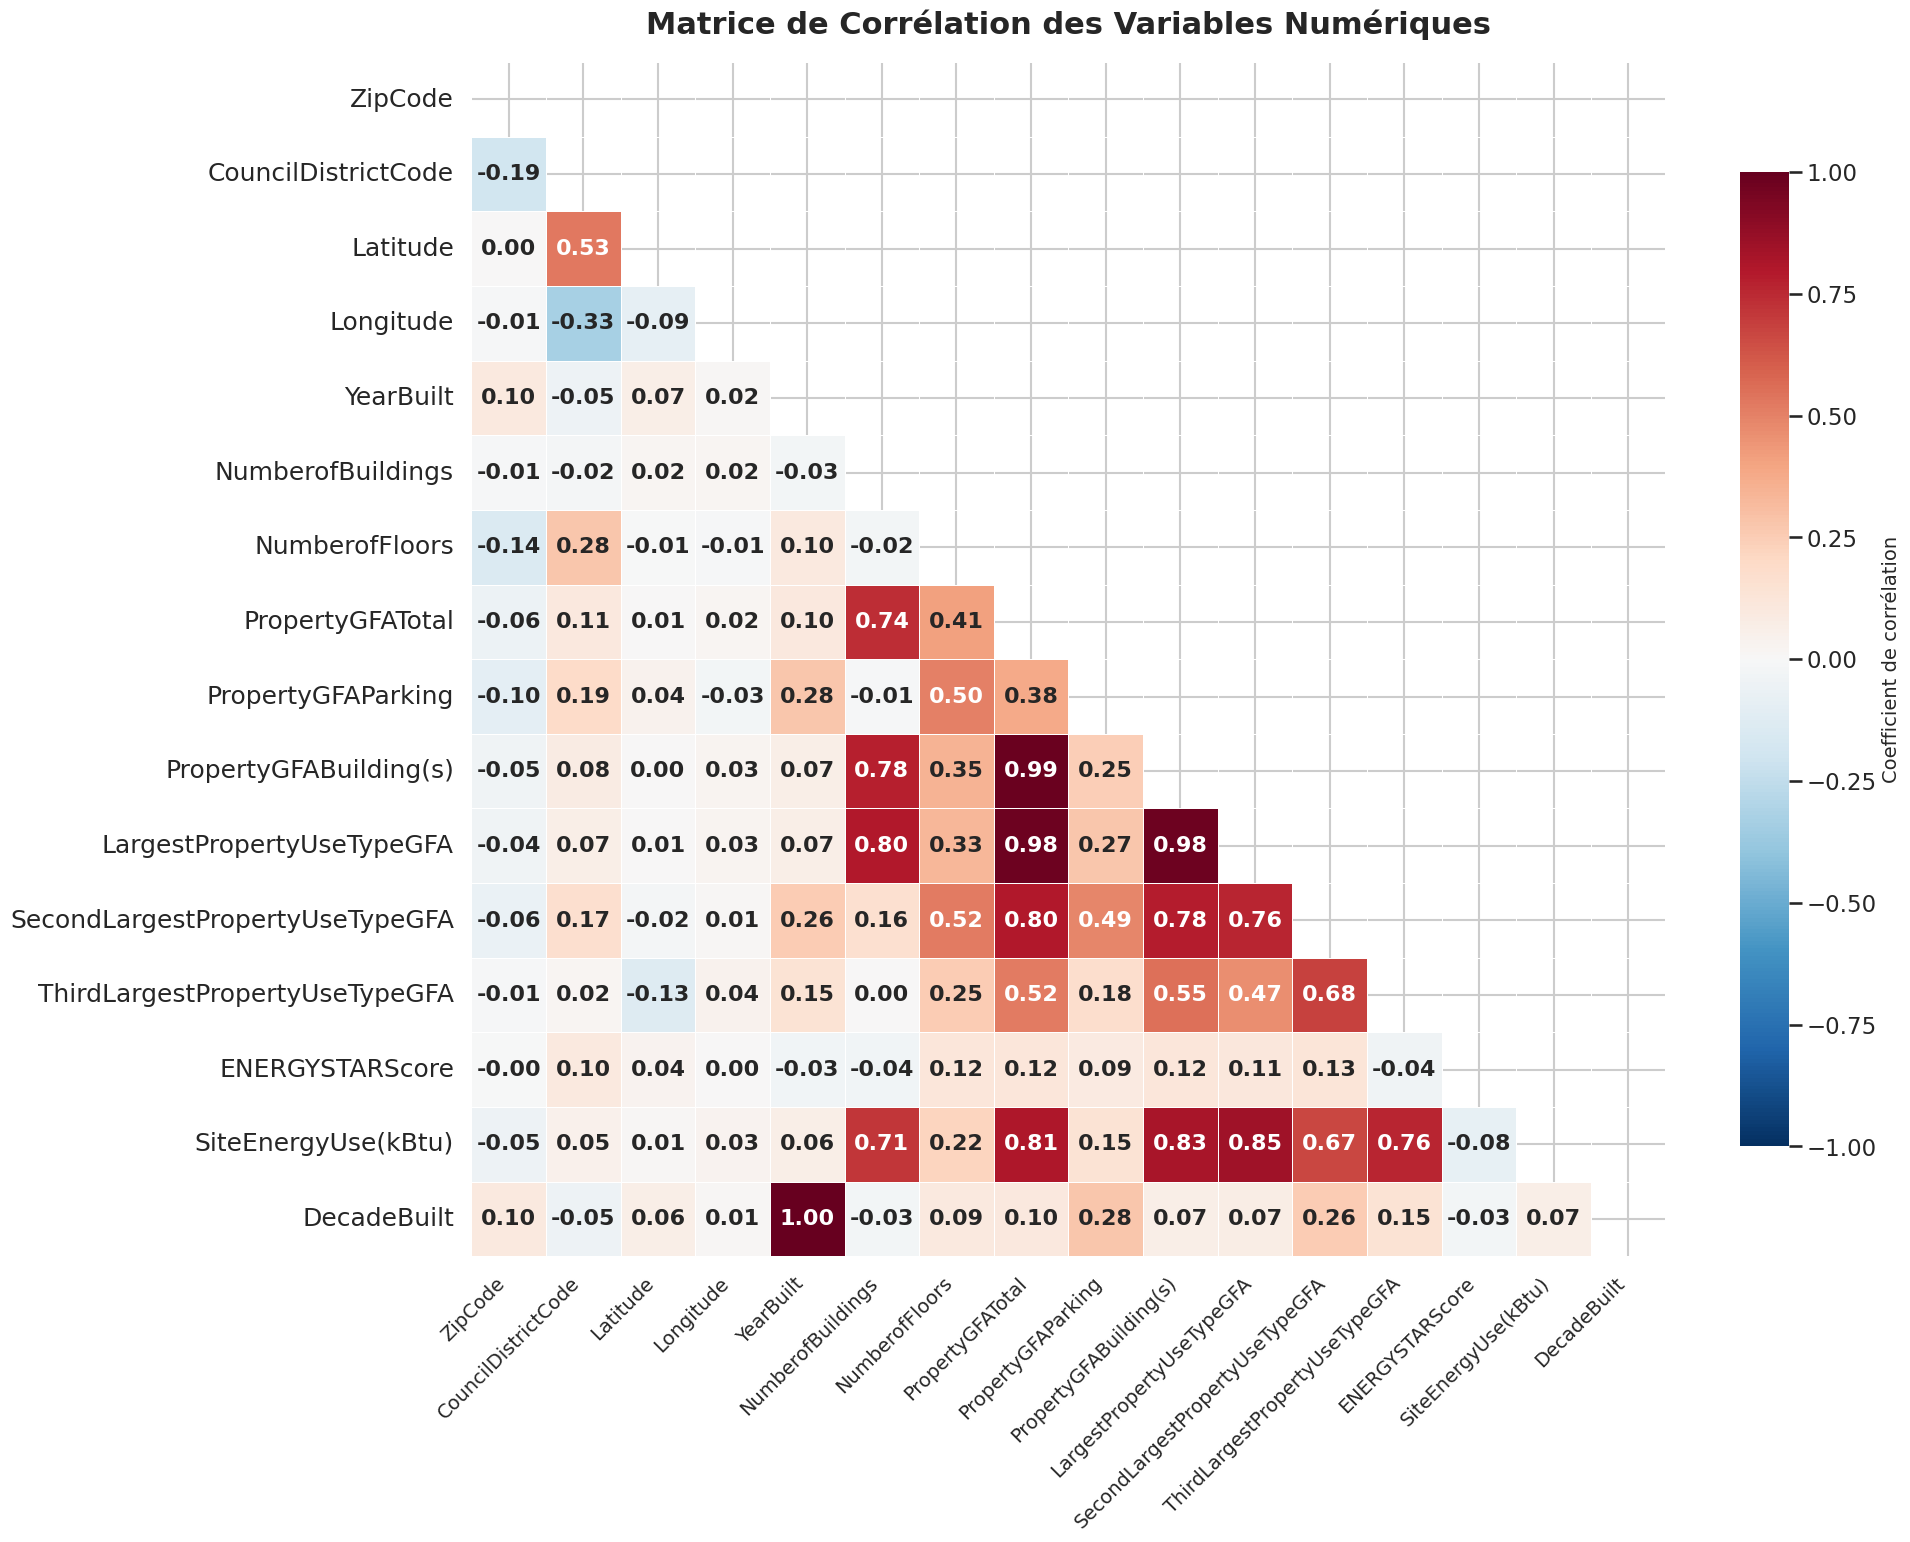

In [ ]:

# Matrice de corrélation
corr = df.select_dtypes(include=[np.number]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Visualisation
plt.figure(figsize=(20, 16), dpi=100)
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Coefficient de corrélation"},
            annot_kws={"size": 16, "weight": "bold"})

plt.title("Matrice de Corrélation des Variables Numériques",
          fontsize=22, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()


## 8. Synthèse Finale de l'Analyse

1. **Corrélation** : On constate une forte corrélation entre Surface totale (`PropertyGFATotal`), les surfaces spécialisées (`PropertyGFABuilding(s)`) et la consommation.
2. **ENERGYSTARScore** : Bien qu'elle soit corrélée négativement à la consommation, son grand nombre de valeurs manquantes posera un défi pour la modélisation (imputation nécessaire).
3. **Structure des données** : L'hétérogénéité des types de propriétés suggère qu'un encodage de certaines variables sera nécessaire.

## 9. Prétraitement : Gestion des Valeurs Manquantes

La gestion des données manquantes est une étape cruciale.

In [ ]:
# Analyse des valeurs manquantes
missing_stats = df.isnull().sum()
missing_stats = missing_stats[missing_stats > 0]
print(" Variables avec des valeurs manquantes :")
print(missing_stats if not missing_stats.empty else "Aucune")

 Variables avec des valeurs manquantes :
ZipCode                              16
LargestPropertyUseType                4
LargestPropertyUseTypeGFA             4
SecondLargestPropertyUseType        796
SecondLargestPropertyUseTypeGFA     796
ThirdLargestPropertyUseType        1297
ThirdLargestPropertyUseTypeGFA     1297
YearsENERGYSTARCertified           1553
ENERGYSTARScore                     557
dtype: int64


Pour l'`ENERGYSTARScore`, nous imputons par la **médiane** de chaque type de bâtiment (`PrimaryPropertyType`). Pour les autres variables, nous supprimons les lignes avec des manquants.

In [ ]:
# 1. Suppression des colonnes trop creuses (>40% de vide)
threshold = 0.4
sparse_cols = [c for c in df.columns if df[c].isnull().sum() / len(df) > threshold]
df.drop(columns=sparse_cols, inplace=True)
print(f" Colonnes supprimées (car trop de manquant) : {sparse_cols}\n")

# 2. Imputation de l'ENERGYSTARScore par la médiane du type de propriété
df['ENERGYSTARScore'] = df['ENERGYSTARScore'].fillna(
    df.groupby('PrimaryPropertyType')['ENERGYSTARScore'].transform('median')
)

# 3. Suppression des lignes restantes avec des valeurs manquantes
df.dropna(inplace=True)

print(f"- Nombre d'observations finales : {df.shape[0]}")
print(f"- Nombre de variables restantes : {df.shape[1]}")

 Colonnes supprimées (car trop de manquant) : ['SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified']

- Nombre d'observations finales : 1558
- Nombre de variables restantes : 19


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1558 entries, 0 to 3356
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               1558 non-null   object 
 1   PrimaryPropertyType        1558 non-null   object 
 2   ZipCode                    1558 non-null   float64
 3   CouncilDistrictCode        1558 non-null   int64  
 4   Neighborhood               1558 non-null   object 
 5   Latitude                   1558 non-null   float64
 6   Longitude                  1558 non-null   float64
 7   YearBuilt                  1558 non-null   int64  
 8   NumberofBuildings          1558 non-null   float64
 9   NumberofFloors             1558 non-null   int64  
 10  PropertyGFATotal           1558 non-null   int64  
 11  PropertyGFAParking         1558 non-null   int64  
 12  PropertyGFABuilding(s)     1558 non-null   int64  
 13  ListOfAllPropertyUseTypes  1558 non-null   object 
 1

Nous allons vérifier la distribution des consommations en fonction des surfaces totales au sol par catégorie de bâtiment. D'éventuels valeurs hors-normes pourraient être repérés et poser des problèmes pour les modélisations

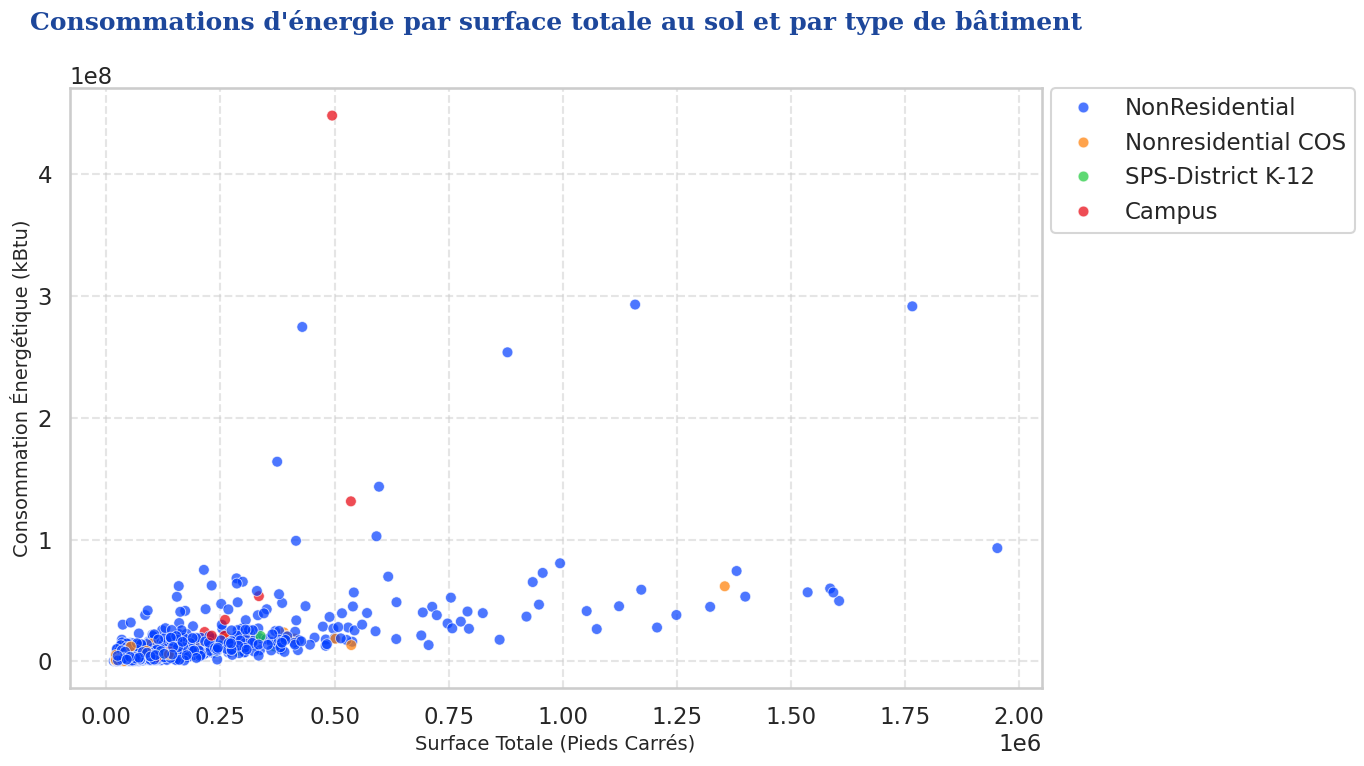

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Définition du style du titre (copié de votre exemple)
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

# 2. Création de la figure
plt.figure(figsize=(14, 8))

# 3. Le Scatterplot avec vos données
sns.scatterplot(data=df,
                x='PropertyGFATotal',
                y='SiteEnergyUse(kBtu)',
                hue='BuildingType',
                s=60,         # Taille des points
                alpha=0.7,    # Transparence
                palette='bright') # Couleurs vives pour bien distinguer

# 4. Titres et Labels
plt.title(f"Consommations d'énergie par surface totale au sol et par type de bâtiment\n",
          fontdict=font_title)
plt.xlabel("Surface Totale (Pieds Carrés)")
plt.ylabel("Consommation Énergétique (kBtu)")

# 5. Grille et Légende
plt.grid(True, linestyle='--', alpha=0.5)
# On met la légende à droite du graphique pour ne pas masquer les points
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

Lors de l'analyse exploratoire bivariée (Consommation vs Surface), nous avons identifié la présence de quelques bâtiments aux caractéristiques extrêmes qui se distinguent nettement du nuage de points principal.Plutôt que de supprimer arbitrairement toute la catégorie 'Campus' , nous avons opté pour une approche ciblée visant à exclure uniquement les valeurs atypiques isolées (High Leverage Points) :Sur l'axe de la consommation : Un groupe restreint de 5 bâtiments (dont le campus principal de l'Université) présente une consommation supérieure à $2.10^8$ kBtu. Ces 'Super-Consommateurs' représenteraiznt des infrastructures uniques  dont le comportement physique diffère radicalement d'un bâtiment  standard.Sur l'axe de la surface : Un bâtiment présente une surface exceptionnellement grande (> 3 millions sqft) pour une consommation paradoxalement faible .Impact sur la modélisation : Conserver ces points aurait forcé les algorithmes (notamment ceux basés sur la minimisation de l'erreur quadratique comme RMSE) à tordre leurs prédictions pour accommoder ces exceptions, dégradant ainsi la performance globale pour les 99% de bâtiments standards. En les retirant, cela garantirait un modèle plus robuste et généralisable."


Dimensions avant nettoyage chirurgical : (1558, 19)
Dimensions après nettoyage chirurgical : (1553, 19)


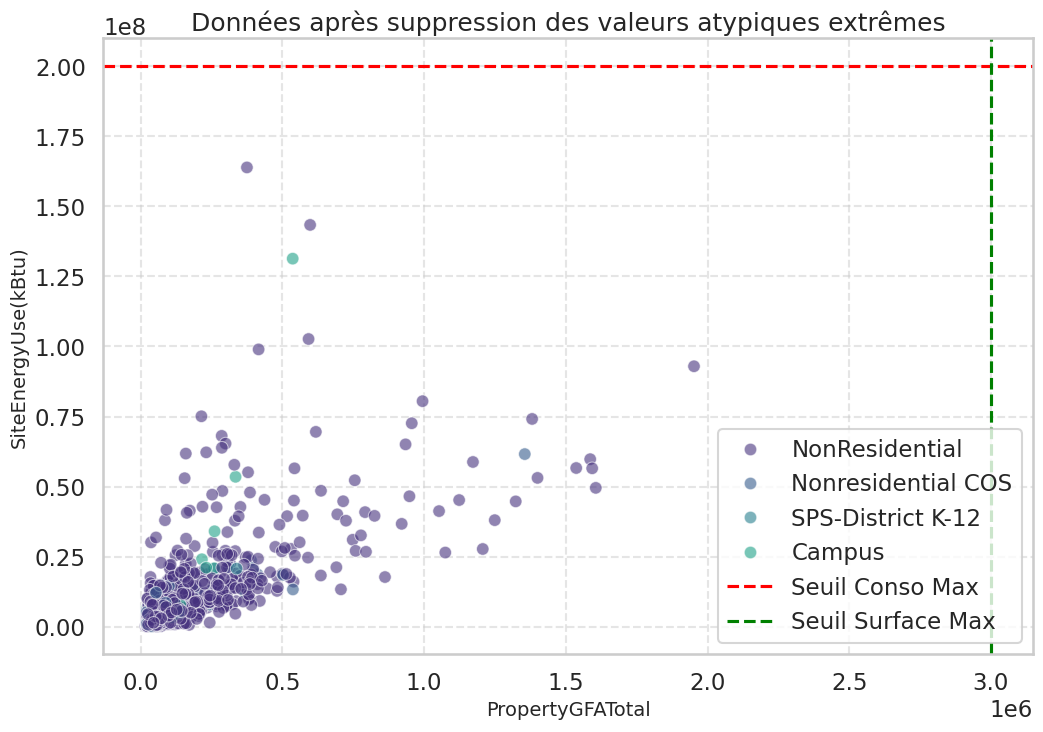

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print(f"Dimensions avant nettoyage chirurgical : {df.shape}")

# 1. FILTRAGE PAR CONSOMMATION (Axe Y)
# Vous avez identifié une barre autour de 2*10^8 (200 millions)
# Cela va éliminer le "point rouge" (souvent l'Université de Washington) et ses 4 suiveurs immédiats.
# Le reste de la catégorie Campus (plus bas) sera conservé.
high_consumption_threshold = 2.0 * 10**8  # 200,000,000 kBtu
df = df[df['SiteEnergyUse(kBtu)'] < high_consumption_threshold].copy()

# 2. FILTRAGE PAR SURFACE (Axe X)
# Pour le point "tout à droite" qui a une surface énorme mais une conso faible.
# En général sur ce dataset, c'est au-dessus de 4 ou 5 millions de pieds carrés.
# On prend une marge de sécurité.
high_surface_threshold = 3.0 * 10**6 # 3,000,000 sqft
df = df[df['PropertyGFATotal'] < high_surface_threshold].copy()

print(f"Dimensions après nettoyage chirurgical : {df.shape}")

# --- VERIFICATION VISUELLE ---
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='PropertyGFATotal', y='SiteEnergyUse(kBtu)', hue='BuildingType', alpha=0.6)
plt.title("Données après suppression des valeurs atypiques extrêmes")
plt.grid(True, linestyle='--', alpha=0.5)
# On trace les lignes de coupe pour montrer ce qu'on a fait
plt.axhline(y=high_consumption_threshold, color='r', linestyle='--', label='Seuil Conso Max')
plt.axvline(x=high_surface_threshold, color='g', linestyle='--', label='Seuil Surface Max')
plt.legend()
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1553 entries, 0 to 3356
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               1553 non-null   object 
 1   PrimaryPropertyType        1553 non-null   object 
 2   ZipCode                    1553 non-null   float64
 3   CouncilDistrictCode        1553 non-null   int64  
 4   Neighborhood               1553 non-null   object 
 5   Latitude                   1553 non-null   float64
 6   Longitude                  1553 non-null   float64
 7   YearBuilt                  1553 non-null   int64  
 8   NumberofBuildings          1553 non-null   float64
 9   NumberofFloors             1553 non-null   int64  
 10  PropertyGFATotal           1553 non-null   int64  
 11  PropertyGFAParking         1553 non-null   int64  
 12  PropertyGFABuilding(s)     1553 non-null   int64  
 13  ListOfAllPropertyUseTypes  1553 non-null   object 
 1

## 10. Transformations des Variables

Comme vu dans l'EDA, la cible est asymétrique. Nous appliquons une transformation logarithmique pour stabiliser la variance.

In [ ]:
# Transformation log de la cible et de la surface
df['SiteEnergyUse_log'] = np.log(df['SiteEnergyUse(kBtu)'])
df['PropertyGFATotal_log'] = np.log(df['PropertyGFATotal'])

print(" Transformations log appliquées.")
print(f"- Nombre d'observations : {df.shape[0]}")
print(f"- Nombre de variables    : {df.shape[1]}")

 Transformations log appliquées.
- Nombre d'observations : 1553
- Nombre de variables    : 21


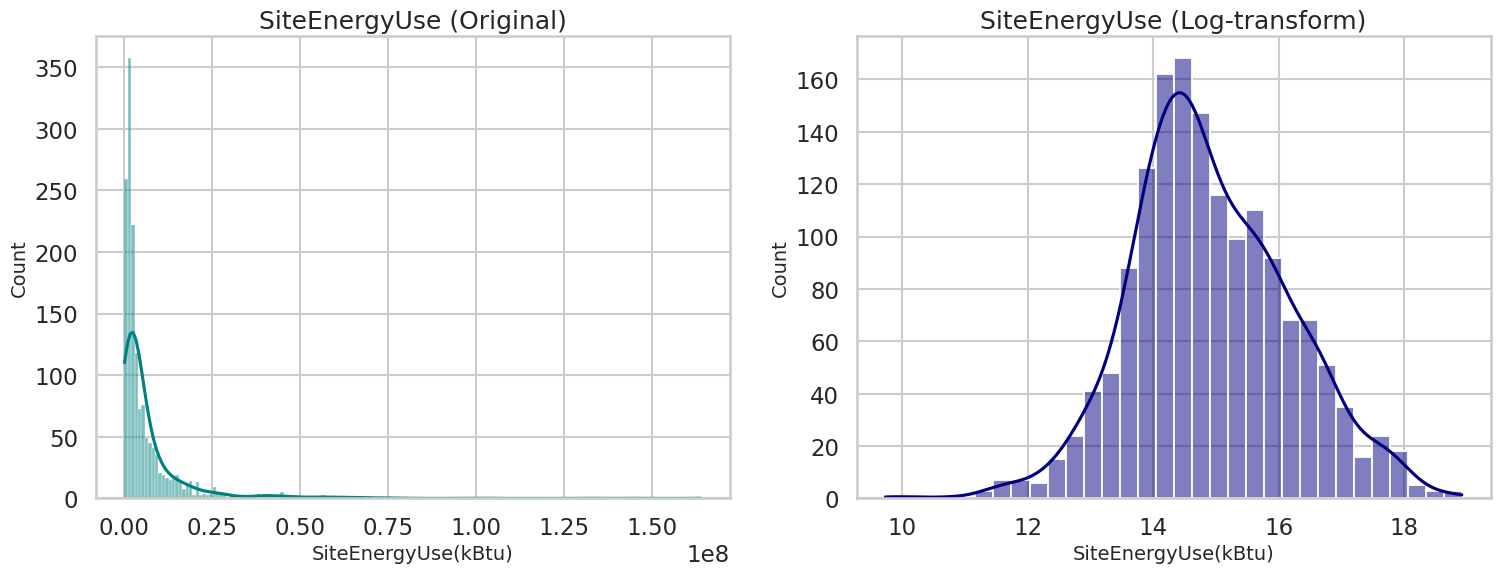

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(df['SiteEnergyUse(kBtu)'], kde=True, ax=ax[0], color='teal')
ax[0].set_title("SiteEnergyUse (Original)")

sns.histplot(np.log(df['SiteEnergyUse(kBtu)']), kde=True, ax=ax[1], color='navy')
ax[1].set_title("SiteEnergyUse (Log-transform)")
plt.show()

Corrélation Surface/Conso (Brut) : 0.7090
Corrélation Surface/Conso (Log)  : 0.7705


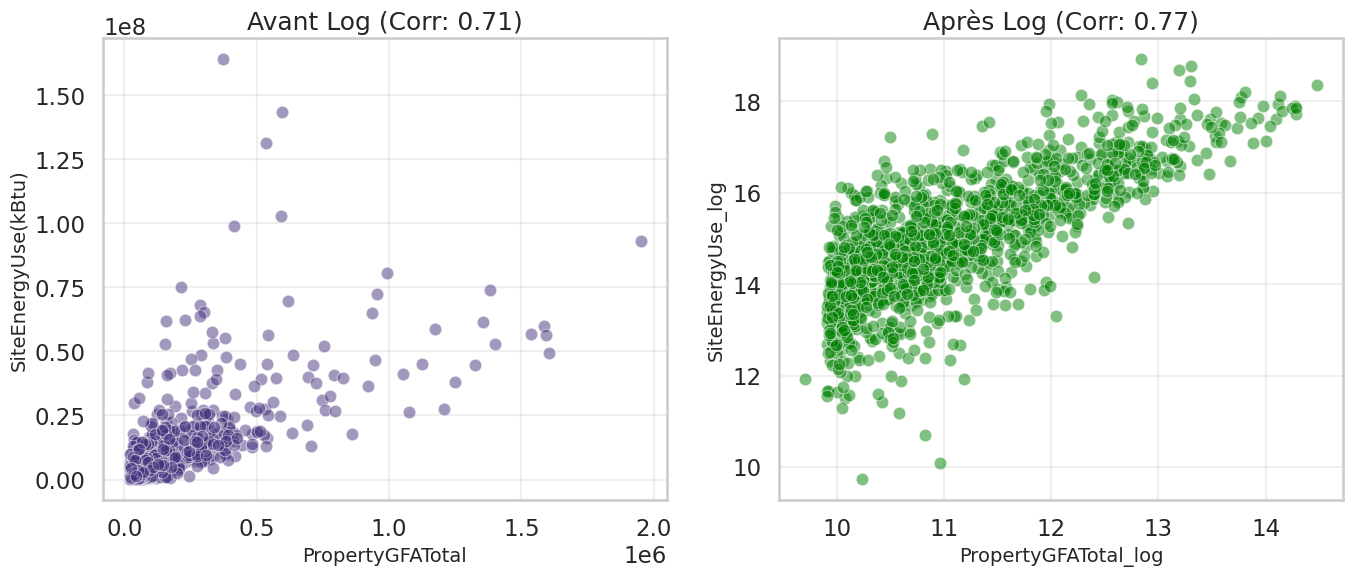

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# 1. Calcul de la corrélation (Pearson)
# Avant Log
corr_brut = df['SiteEnergyUse(kBtu)'].corr(df['PropertyGFATotal'])
# Après Log
corr_log = df['SiteEnergyUse_log'].corr(df['PropertyGFATotal_log'])

print(f"Corrélation Surface/Conso (Brut) : {corr_brut:.4f}")
print(f"Corrélation Surface/Conso (Log)  : {corr_log:.4f}")

# 2. Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1 : Données Brutes
sns.scatterplot(ax=axes[0], data=df, x='PropertyGFATotal', y='SiteEnergyUse(kBtu)', alpha=0.5)
axes[0].set_title(f'Avant Log (Corr: {corr_brut:.2f})')
axes[0].grid(True, alpha=0.3)

# Graphique 2 : Données Log
sns.scatterplot(ax=axes[1], data=df, x='PropertyGFATotal_log', y='SiteEnergyUse_log', alpha=0.5, color='green')
axes[1].set_title(f'Après Log (Corr: {corr_log:.2f})')
axes[1].grid(True, alpha=0.3)

plt.show()

## 11. Encodage des Variables Catégorielles

### 11.1 Le One-Hot Encoding
Nous transformons les variables textuelles en variables numériques (One-Hot Encoding) pour permettre l'apprentissage.

In [ ]:
!pip install category_encoders

In [ ]:
import pandas as pd
import category_encoders as ce
from sklearn.preprocessing import MultiLabelBinarizer

# On suppose que 'df' est votre dataframe nettoyé actuel (après log, outliers, etc.)

# =====================================================
# 1. PRÉPARATION COMMUNE (Nettoyage & MLB)
# =====================================================
print(">>> PRÉPARATION DES DONNÉES...")

# Variables catégorielles standards
std_cat_cols = ['PrimaryPropertyType', 'BuildingType', 'Neighborhood', 'LargestPropertyUseType']
std_cat_cols = [c for c in std_cat_cols if c in df.columns]

# Nettoyage des chaînes (Minuscules, espaces)
for col in std_cat_cols:
    df[col] = df[col].astype(str).str.strip().str.lower()

# Traitement de la variable Liste (MultiLabel)
# On crée la liste propre
list_col = 'ListOfAllPropertyUseTypes'
if list_col in df.columns:
    # Nettoyage en liste python
    temp_list = df[list_col].fillna('').astype(str).apply(lambda x: [i.strip().lower() for i in x.split(',')] if x != '' else [])

    # Encodage MLB (Multi-Hot)
    mlb = MultiLabelBinarizer()
    df_mlb = pd.DataFrame(
        mlb.fit_transform(temp_list),
        columns=[f"use_{c}" for c in mlb.classes_],
        index=df.index
    )
    print(f"   -> Variable 'ListOfAllPropertyUseTypes' éclatée en {df_mlb.shape[1]} colonnes (MLB).")
else:
    df_mlb = pd.DataFrame(index=df.index) # Vide si la colonne n'existe pas

# On prépare le socle numérique (sans les cat, sans la liste)
cols_to_exclude = std_cat_cols + [list_col, 'ListOfAllPropertyUseTypes_clean']
df_numeric = df.drop(columns=[c for c in cols_to_exclude if c in df.columns], errors='ignore')

# =====================================================
# SCÉNARIO A : FULL ONE-HOT ENCODING
# =====================================================
print("\n" + "="*50)
print("SCÉNARIO A : FULL ONE-HOT ENCODING")
print("="*50)

# On applique One-Hot sur les variables standards (Neighborhood, etc.)
# drop_first=True évite la colinéarité parfaite (Dummy Trap)
df_std_onehot = pd.get_dummies(df[std_cat_cols], prefix=std_cat_cols, drop_first=True)

# Fusion : Numérique + MLB + OneHot
df_full_onehot = pd.concat([df_numeric, df_mlb, df_std_onehot], axis=1)

print(f"Nombre de variables (Original) : {df.shape[1]}")
print(f"Nombre de variables (One-Hot)  : {df_full_onehot.shape[1]}")
print(f"Gain/Perte de dimension        : +{df_full_onehot.shape[1] - df.shape[1]}")

# =====================================================
# SCÉNARIO B : BINARY ENCODING
# =====================================================
print("\n" + "="*50)
print("SCÉNARIO B : BINARY ENCODING")
print("="*50)

# On applique Binary sur les variables standards
encoder_bin = ce.BinaryEncoder(cols=std_cat_cols)
df_std_binary = encoder_bin.fit_transform(df[std_cat_cols])

# Fusion : Numérique + MLB + Binary
df_full_binary = pd.concat([df_numeric, df_mlb, df_std_binary], axis=1)

print(f"Nombre de variables (Original) : {df.shape[1]}")
print(f"Nombre de variables (Binary)   : {df_full_binary.shape[1]}")
print(f"Gain/Perte de dimension        : +{df_full_binary.shape[1] - df.shape[1]}")

# =====================================================
# CHOIX ET SAUVEGARDE
# =====================================================
# Pour l'instant, stockons les deux résultats
# Vous pourrez choisir df_encoded = df_full_onehot ou df_full_binary

>>> PRÉPARATION DES DONNÉES...
   -> Variable 'ListOfAllPropertyUseTypes' éclatée en 68 colonnes (MLB).

SCÉNARIO A : FULL ONE-HOT ENCODING
Nombre de variables (Original) : 21
Nombre de variables (One-Hot)  : 166
Gain/Perte de dimension        : +145

SCÉNARIO B : BINARY ENCODING
Nombre de variables (Original) : 21
Nombre de variables (Binary)   : 102
Gain/Perte de dimension        : +81


Justification du choix du Target Encoding *"Face à la forte cardinalité de certaines variables catégorielles (notamment Neighborhood et ListOfAllPropertyUseTypes), les méthodes classiques comme le One-Hot Encoding généraient un nombre excessif de dimensions (phénomène d'explosion dimensionnelle), diluant l'information et augmentant le risque de sur-apprentissage.

Nous avons donc opté pour le Target Encoding. Cette technique remplace chaque catégorie par la moyenne de la cible (log-consommation) observée pour cette catégorie. Cela permet de :

Maintenir un nombre constant de variables (pas d'augmentation de dimension).

Capturer directement l'influence métier de la catégorie (ex: le fait qu'un quartier soit intrinsèquement plus énergivore).

Utiliser un paramètre de lissage (smoothing) pour éviter le sur-ajustement sur les catégories rares."*

## 12. Création de Nouvelles Features & Synthèse

Nous pouvons créer des variables plus explicites pour aider le modèle.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# ==============================================================================
# 1. CRÉATION DES VARIABLES GÉOGRAPHIQUES & TEMPORELLES
# ==============================================================================

# Coordonnées du centre de Seattle
SEATTLE_CENTER_LAT = 47.6062
SEATTLE_CENTER_LON = -122.3321



#SEATTLE_CENTER_LAT = 47.6097
#SEATTLE_CENTER_LON = -122.3331


def haversine_vectorized(lat1, lon1, lat2, lon2):
    """Distance de Haversine vectorisée (km)"""
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c

print(">>> DÉBUT DU FEATURE ENGINEERING...")

# A. Distance au centre
df['Distance_to_Center'] = haversine_vectorized(
    df['Latitude'], df['Longitude'],
    SEATTLE_CENTER_LAT, SEATTLE_CENTER_LON
)

# B. Clustering Spatial (Quartiers artificiels basés sur la densité)
# Utile pour capturer des zones non définies par les codes postaux
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
df['Neighborhood_Cluster'] = kmeans.fit_predict(df[['Latitude', 'Longitude']])

# C. Indicateur Centre-Ville (< 2km)
df['Is_Downtown'] = (df['Distance_to_Center'] < 2).astype(int)

# D. Coordonnées Rotatées (30°)
# Aide les arbres de décision à couper "en diagonale" par rapport au nord géographique
angle_rad = np.radians(30)
df['Rotated_Lat'] = df['Latitude'] * np.cos(angle_rad) - df['Longitude'] * np.sin(angle_rad)
df['Rotated_Lon'] = df['Latitude'] * np.sin(angle_rad) + df['Longitude'] * np.cos(angle_rad)

# E. Âge du Bâtiment
# Si la colonne BuildingAge n'existe pas encore (ou pour être sûr)
if 'YearBuilt' in df.columns:
    df['BuildingAge'] = 2016 - df['YearBuilt']
    df.drop(columns=['YearBuilt'], inplace=True)

# Nettoyage des colonnes sources devenues inutiles
cols_to_drop_geo = ['Latitude', 'Longitude', 'DecadeBuilt', 'YearBuilt']
df.drop(columns=[c for c in cols_to_drop_geo if c in df.columns], inplace=True)

print("Feature Engineering terminé.")
print(f"Nouvelles dimensions : {df.shape}")

>>> DÉBUT DU FEATURE ENGINEERING...
Feature Engineering terminé.
Nouvelles dimensions : (1553, 23)


In [ ]:
'''
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# ==============================================================================
# INSERTION : CRÉATION DE PROFILS (CLUSTERING & INTERACTIONS)
# ==============================================================================
print(">>> CRÉATION DES PROFILS STRUCTURELS...")

# --- 1. CLUSTERING STRUCTUREL (MORPHOLOGIE) ---
# On va grouper les bâtiments selon leur "physique" : Surface et Hauteur
# Cela aide le modèle à distinguer un "Petit Haut" d'un "Grand Plat"
morpho_cols = ['PropertyGFATotal']
# On vérifie que les colonnes existent
morpho_cols = [c for c in morpho_cols if c in df.columns]

# Scaling temporaire juste pour le KMeans (le KMeans est sensible aux échelles)
scaler_km = StandardScaler()
X_morpho = scaler_km.fit_transform(df[morpho_cols])

# On crée 5 profils types (ex: Petit, Moyen, Grand, Très Grand, Gratte-ciel)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df['Morphology_Cluster'] = kmeans.fit_predict(X_morpho)

# On transforme le cluster en chaîne de caractères pour qu'il soit traité comme une catégorie
df['Morphology_Cluster'] = "Cluster_" + df['Morphology_Cluster'].astype(str)

print(f"-> 5 Clusters morphologiques créés (Répartition) :\n{df['Morphology_Cluster'].value_counts()}")

# --- 2. INTERACTION SURFACE x TYPE (La réponse à votre intuition) ---
# On veut dire au modèle : "Surface * Intensité du Type"
# Problème : On ne peut pas multiplier par du texte.
# Solution : On utilise le Target Encoding temporaire du Type pour pondérer la Surface.

# On calcule une moyenne brute de l'intensité par type (sur tout le dataset pour l'ingénierie)
# Note : C'est une approximation pour l'ingénierie, le vrai Target Encoding se fera après le split
avg_intensity_by_type = df.groupby('LargestPropertyUseType')['SiteEnergyUse_log'].transform('mean')

# Nouvelle variable : Surface pondérée par la gourmandise du type
df['Weighted_Surface_Log'] = df['PropertyGFATotal_log'] * avg_intensity_by_type

print("-> Variable 'Weighted_Surface_Log' créée.")
'''

'\nfrom sklearn.cluster import KMeans\nfrom sklearn.preprocessing import StandardScaler\n\n# ==============================================================================\n# INSERTION : CRÉATION DE PROFILS (CLUSTERING & INTERACTIONS)\n# ==============================================================================\nprint(">>> CRÉATION DES PROFILS STRUCTURELS...")\n\n# --- 1. CLUSTERING STRUCTUREL (MORPHOLOGIE) ---\n# On va grouper les bâtiments selon leur "physique" : Surface et Hauteur\n# Cela aide le modèle à distinguer un "Petit Haut" d\'un "Grand Plat"\nmorpho_cols = [\'PropertyGFATotal\']\n# On vérifie que les colonnes existent\nmorpho_cols = [c for c in morpho_cols if c in df.columns]\n\n# Scaling temporaire juste pour le KMeans (le KMeans est sensible aux échelles)\nscaler_km = StandardScaler()\nX_morpho = scaler_km.fit_transform(df[morpho_cols])\n\n# On crée 5 profils types (ex: Petit, Moyen, Grand, Très Grand, Gratte-ciel)\nkmeans = KMeans(n_clusters=5, random_state=42, n_ini

In [ ]:

from sklearn.cluster import KMeans

# ==============================================================================
# INSERTION : CLUSTERING SIMPLIFIÉ (SURFACE UNIQUEMENT)
# ==============================================================================
print(">>> CRÉATION DU CLUSTER DE SURFACE...")

# On utilise la surface Log qui est déjà normalisée
# On choisit 4 groupes : Petit, Moyen, Grand, Très Grand
kmeans_surf = KMeans(n_clusters=2, random_state=42, n_init=10)

# Le double crochet [['...']] est important pour que sklearn le voie comme un DataFrame 2D
df['Surface_Cluster'] = kmeans_surf.fit_predict(df[['PropertyGFATotal_log']])

# On transforme en texte pour que ce soit traité comme une catégorie (Target Encoding plus tard)
df['Surface_Cluster'] = "Surf_Group_" + df['Surface_Cluster'].astype(str)

print(f"-> Répartition des bâtiments par taille :\n{df['Surface_Cluster'].value_counts().sort_index()}")

# Petit check visuel des moyennes de conso par groupe pour voir si ça discrimine bien
print("\n-> Consommation moyenne (Log) par groupe de surface :")
print(df.groupby('Surface_Cluster')['SiteEnergyUse_log'].mean().sort_values())


>>> CRÉATION DU CLUSTER DE SURFACE...
-> Répartition des bâtiments par taille :
Surface_Cluster
Surf_Group_0     483
Surf_Group_1    1070
Name: count, dtype: int64

-> Consommation moyenne (Log) par groupe de surface :
Surface_Cluster
Surf_Group_1    14.351787
Surf_Group_0    16.146713
Name: SiteEnergyUse_log, dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split

# ==============================================================================
# 2. PRÉPARATION ML & SPLIT
# ==============================================================================

# A. Définition de la Cible et des Features
target_col = 'SiteEnergyUse_log'

# Liste des colonnes à exclure (Cibles brutes, Infos administratives, Doublons)
cols_to_exclude = [
    'SiteEnergyUse(kBtu)', 'SiteEnergyUse_log',       # Cibles
    'EnergyIntensity', 'EnergyIntensity_Log',         # Cibles alternatives
    'PropertyGFATotal',                               # On utilise le Log
    'OSEBuildingID', 'DataYear',                      # Identifiants
    'ListOfAllPropertyUseTypes', 'ListOfAllPropertyUseTypes_clean' # Texte brut
]

# Création de X et y
X = df.drop(columns=[c for c in cols_to_exclude if c in df.columns], errors='ignore')
y = df[target_col]

# B. Split Train / Test (80% / 20%)
# random_state=42 assure que vous aurez toujours le même découpage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dimensions Train : {X_train.shape}")
print(f"Dimensions Test  : {X_test.shape}")

Dimensions Train : (1242, 20)
Dimensions Test  : (311, 20)


In [ ]:
import category_encoders as ce

# ==============================================================================
# 3. TARGET ENCODING
# ==============================================================================
print("\n>>> APPLICATION DU TARGET ENCODING...")

# Identification automatique des colonnes catégorielles restantes
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Variables catégorielles à encoder : {cat_cols}")

# Initialisation de l'encodeur
# smoothing=10 : Si une catégorie a peu d'exemples, on la rapproche de la moyenne globale
# handle_unknown='value' : Si une catégorie inconnue arrive dans le test, on met la moyenne globale
encoder = ce.TargetEncoder(cols=cat_cols, smoothing=10, handle_unknown='value')

# 1. FIT & TRANSFORM sur le TRAIN (Le modèle apprend les moyennes par catégorie)
X_train_encoded = encoder.fit_transform(X_train, y_train)

# 2. TRANSFORM sur le TEST (On applique les moyennes apprises sans regarder y_test)
X_test_encoded = encoder.transform(X_test)

# Sauvegarde finale pour les modèles
X_train_final = X_train_encoded
X_test_final = X_test_encoded

print("Encodage terminé.")
print(f"Nombre de variables final : {X_train_final.shape[1]}")
print("Aperçu des 5 premières lignes du Train encodé :")
print(X_train_final.head())


>>> APPLICATION DU TARGET ENCODING...
Variables catégorielles à encoder : ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'Surface_Cluster']
Encodage terminé.
Nombre de variables final : 20
Aperçu des 5 premières lignes du Train encodé :
      BuildingType  PrimaryPropertyType  ZipCode  CouncilDistrictCode  Neighborhood  NumberofBuildings  NumberofFloors  PropertyGFAParking  PropertyGFABuilding(s)  LargestPropertyUseType  LargestPropertyUseTypeGFA  ENERGYSTARScore  PropertyGFATotal_log  Distance_to_Center  Neighborhood_Cluster  Is_Downtown  Rotated_Lat  Rotated_Lon  BuildingAge  Surface_Cluster
2467     14.901364            15.354249  98101.0                    7     14.909502                1.0               6               26082                   69035               15.354249                    69035.0              1.0             11.462863            0.850214                     3            1   102.397958   -82.132107           47        16.151353

### Résumé du Dataset Final

**Justification** : Nous utilisons la version logarithmique pour la cible afin d'améliorer la convergence des modèles linéaires.

-------------------Là commencent les modèles-------------------

#########avec la nouvelle modélisation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Configuration d'affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# --- FONCTION D'ÉVALUATION (Inchangée) ---
def evaluate_performance(model, X, y_log, dataset_name="Test"):
    y_pred_log = model.predict(X)
    y_real = np.exp(y_log)
    y_pred_real = np.exp(y_pred_log)

    # Métriques Log
    rmse_log = np.sqrt(mean_squared_error(y_log, y_pred_log))
    r2_log = r2_score(y_log, y_pred_log)

    # Métriques Réelles
    rmse_real = np.sqrt(mean_squared_error(y_real, y_pred_real))
    mae_real = mean_absolute_error(y_real, y_pred_real)
    mape_real = mean_absolute_percentage_error(y_real, y_pred_real)
    r2_real = r2_score(y_real, y_pred_real)

    prefix = dataset_name + "_"
    return {
        f'{prefix}RMSE_Log': rmse_log,
        f'{prefix}R2_Log': r2_log,
        f'{prefix}RMSE_Real': rmse_real,
        f'{prefix}MAE_Real': mae_real,
        f'{prefix}MAPE_Real': mape_real, # <--- Le plus important
        f'{prefix}R2_Real': r2_real
    }

# --- FONCTION UTILE : GESTION ENERGY STAR ---
def prepare_xy_for_scenario(X_train, X_test, use_energy_star):
    # Si on ne veut pas le score, on supprime la colonne
    if not use_energy_star and 'ENERGYSTARScore' in X_train.columns:
        return X_train.drop(columns=['ENERGYSTARScore']), X_test.drop(columns=['ENERGYSTARScore'])
    return X_train.copy(), X_test.copy()

In [ ]:
def train_linear_models(X_train_src, X_test_src, y_train, y_test, use_energy_star=False):
    print(f"\n>>> [LINEAR] SCÉNARIO : AVEC ENERGY STAR = {use_energy_star} ...")

    # 1. Adaptation des données (Suppression ou non du score)
    X_train_curr, X_test_curr = prepare_xy_for_scenario(X_train_src, X_test_src, use_energy_star)

    # 2. Pipeline (Imputer + Scaler obligatoires pour linéaire)
    # Note: Target Encoding a déjà rendu tout numérique, donc on scale tout
    preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # 3. Modèles
    models_config = {
        'LinearRegression': (LinearRegression(), {}),

        'Ridge': (Ridge(random_state=42), {
            'model__alpha': [0.01, 0.1, 1, 10, 50, 100]  # Ajout de 0.01, 50, 100
        }),

        'Lasso': (Lasso(random_state=42, max_iter=5000), {  # max_iter augmenté pour éviter les warnings
            'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1]  # Ajout de 0.0001 et 1
        }),

        'ElasticNet': (ElasticNet(random_state=42, max_iter=5000), {
            'model__alpha': [0.001, 0.01, 0.1, 1],        # Ajout de 0.001 et 1
            'model__l1_ratio': [0.1, 0.5, 0.9]            # Ajout de 0.1 et 0.9 (Mix Ridge/Lasso)
        }),

        'SVM_Linear': (LinearSVR(random_state=42, max_iter=10000, dual='auto'), {
            'model__C': [0.01, 0.1, 1, 10, 100]           # Ajout de 0.01 et 100
        })
    }

    results = []
    for name, (model, params) in models_config.items():
        pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
        grid = GridSearchCV(pipe, params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
        grid.fit(X_train_curr, y_train)

        metrics_train = evaluate_performance(grid.best_estimator_, X_train_curr, y_train, "Train")
        metrics_test = evaluate_performance(grid.best_estimator_, X_test_curr, y_test, "Test")

        res = {'Scenario': 'With Score' if use_energy_star else 'No Score', 'Model': name}
        res.update(metrics_train)
        res.update(metrics_test)
        results.append(res)

    return pd.DataFrame(results)

In [ ]:
def train_simple_nonlinear(X_train_src, X_test_src, y_train, y_test, use_energy_star=False):
    print(f"\n>>> [SIMPLE NON-LINEAR] SCÉNARIO : AVEC ENERGY STAR = {use_energy_star} ...")

    # 1. Préparation des données (selon scénario avec ou sans ENERGY STAR)
    X_train_curr, X_test_curr = prepare_xy_for_scenario(X_train_src, X_test_src, use_energy_star)

    # 2. Préprocesseur
    # KNN a besoin de scaling, Arbre s'en fiche (mais ça ne fait pas de mal)
    preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # 3. Modèles et hyperparamètres
    models_config = {
        'KNN': (KNeighborsRegressor(), {
            'model__n_neighbors': [3, 5, 10, 15, 20],   # Ajout de 3 et 20
            'model__weights': ['uniform', 'distance'],  # On teste les deux
            'model__p': [1, 2]                          # 1 = Manhattan, 2 = Euclidien
        }),

        'DecisionTree': (DecisionTreeRegressor(random_state=42), {
            'model__max_depth': [5, 10, 15, 20, None],  # Ajout de 20
            'model__min_samples_leaf': [2, 5, 10, 20],  # Ajout de 2 et 20
            'model__min_samples_split': [2, 10]         # Nouveau paramètre
        })
    }

    # 4. Entraînement et évaluation
    results = []
    for name, (model, params) in models_config.items():
        pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
        grid = GridSearchCV(pipe, params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
        grid.fit(X_train_curr, y_train)

        metrics_train = evaluate_performance(grid.best_estimator_, X_train_curr, y_train, "Train")
        metrics_test = evaluate_performance(grid.best_estimator_, X_test_curr, y_test, "Test")

        res = {'Scenario': 'With Score' if use_energy_star else 'No Score', 'Model': name}
        res.update(metrics_train)
        res.update(metrics_test)
        results.append(res)

    # 5. Retour des résultats sous forme de DataFrame
    return pd.DataFrame(results)

In [ ]:
def train_ensemble_models(X_train_src, X_test_src, y_train, y_test, use_energy_star=False):
    print(f"\n>>> [ENSEMBLE] SCÉNARIO : AVEC ENERGY STAR = {use_energy_star} ...")

    X_train_curr, X_test_curr = prepare_xy_for_scenario(
        X_train_src, X_test_src, use_energy_star
    )

    # Pas besoin de StandardScaler pour les arbres ensemblistes, juste Imputer
    preprocessor = SimpleImputer(strategy='median')

    models_config = {
        'RandomForest': (
            RandomForestRegressor(random_state=42),
            {
                'model__n_estimators': [100, 200, 300, 500],
                'model__max_depth': [10, 20, 30, None],
                'model__min_samples_leaf': [1, 2, 4]
            }
        ),

        'ExtraTrees': (
            ExtraTreesRegressor(random_state=42),
            {
                'model__n_estimators': [100, 300, 500],
                'model__max_depth': [10, 20, None],
                'model__min_samples_leaf': [1, 2]
            }
        ),

        'XGBoost': (
            XGBRegressor(random_state=42, objective='reg:squarederror'),
            {
                'model__n_estimators': [100, 300, 500],
                'model__learning_rate': [0.01, 0.05, 0.1],
                'model__max_depth': [3, 6, 9],
                'model__subsample': [0.8, 1.0]
            }
        ),

        'LightGBM': (
            LGBMRegressor(random_state=42, verbose=-1),
            {
                'model__n_estimators': [100, 300, 500],
                'model__learning_rate': [0.01, 0.05, 0.1],
                'model__num_leaves': [20, 31, 50, 100]
            }
        ),

        'HistGradientBoosting': (
            HistGradientBoostingRegressor(random_state=42),
            {
                'model__learning_rate': [0.01, 0.05, 0.1],
                'model__max_iter': [100, 200, 300],
                'model__max_depth': [None, 10, 20],
                'model__l2_regularization': [0, 0.1]
            }
        )
    }

    results = []

    for name, (model, params) in models_config.items():
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        grid = GridSearchCV(
            pipe,
            params,
            cv=3,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        )

        grid.fit(X_train_curr, y_train)

        metrics_train = evaluate_performance(
            grid.best_estimator_, X_train_curr, y_train, "Train"
        )
        metrics_test = evaluate_performance(
            grid.best_estimator_, X_test_curr, y_test, "Test"
        )

        res = {
            'Scenario': 'With Score' if use_energy_star else 'No Score',
            'Model': name
        }
        res.update(metrics_train)
        res.update(metrics_test)

        results.append(res)

    return pd.DataFrame(results)


In [ ]:
# --- LANCEMENT DES TRAITEMENTS ---

# 1. Modèles Linéaires
df_linear_no = train_linear_models(X_train_final, X_test_final, y_train, y_test, use_energy_star=False)
df_linear_yes = train_linear_models(X_train_final, X_test_final, y_train, y_test, use_energy_star=True)

# 2. Modèles Simples
df_simple_no = train_simple_nonlinear(X_train_final, X_test_final, y_train, y_test, use_energy_star=False)
df_simple_yes = train_simple_nonlinear(X_train_final, X_test_final, y_train, y_test, use_energy_star=True)

# 3. Modèles Ensemblistes
df_ensemble_no = train_ensemble_models(X_train_final, X_test_final, y_train, y_test, use_energy_star=False)
df_ensemble_yes = train_ensemble_models(X_train_final, X_test_final, y_train, y_test, use_energy_star=True)

# --- CONSOLIDATION ---
all_results = pd.concat([
    df_linear_no, df_linear_yes,
    df_simple_no, df_simple_yes,
    df_ensemble_no, df_ensemble_yes
], ignore_index=True)

# --- AFFICHAGE FINAL ---
cols_to_show = [
    'Scenario', 'Model',
    'Test_MAPE_Real',  # Critère n°1
    'Test_R2_Real',    # Critère n°2
    'Test_R2_Log',     # Critère technique
    'Train_R2_Real'    # Pour vérifier l'overfitting
]

print("\n" + "="*80)
print("CLASSEMENT FINAL DES MODÈLES (PAR MAPE CROISSANTE)")
print("="*80)
print(all_results[cols_to_show].sort_values(by='Test_MAPE_Real', ascending=True).round(4).to_string(index=False))


>>> [LINEAR] SCÉNARIO : AVEC ENERGY STAR = False ...

>>> [LINEAR] SCÉNARIO : AVEC ENERGY STAR = True ...

>>> [SIMPLE NON-LINEAR] SCÉNARIO : AVEC ENERGY STAR = False ...

>>> [SIMPLE NON-LINEAR] SCÉNARIO : AVEC ENERGY STAR = True ...

>>> [ENSEMBLE] SCÉNARIO : AVEC ENERGY STAR = False ...

>>> [ENSEMBLE] SCÉNARIO : AVEC ENERGY STAR = True ...

CLASSEMENT FINAL DES MODÈLES (PAR MAPE CROISSANTE)
  Scenario                Model  Test_MAPE_Real  Test_R2_Real  Test_R2_Log  Train_R2_Real
With Score           ExtraTrees          0.4092        0.5186       0.7823         0.9142
With Score HistGradientBoosting          0.4302        0.6078       0.7739         0.8931
With Score             LightGBM          0.4307        0.5961       0.7802         0.7748
With Score              XGBoost          0.4317        0.5733       0.7790         0.7990
With Score         RandomForest          0.4349        0.5363       0.7631         0.8314
With Score     LinearRegression          0.4496        0.5896